### Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Load & Inspect Data

In [2]:
df = pd.read_csv("../data/titanic.csv")
df.info()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data Cleaning & Preprocessing

In [3]:
# Fill missing values
df['Age'].fillna(df['Age'].median())
df['Embarked'].fillna(df['Embarked'].mode()[0])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [4]:

# Drop unnecessary columns
df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)


In [5]:
# Encode categorical features
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,False,True
1,2,1,1,0,38.0,1,0,71.2833,False,False
2,3,1,3,0,26.0,0,0,7.9250,False,True
3,4,1,1,0,35.0,1,0,53.1000,False,True
4,5,0,3,1,35.0,0,0,8.0500,False,True


### Train-Test Split

In [12]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age            140
SibSp            0
Parch            0
Fare             0
Embarked_Q       0
Embarked_S       0
dtype: int64

In [15]:
age_median = X_train['Age'].median()
X_train['Age'] = X_train['Age'].fillna(age_median)
X_test['Age'] = X_test['Age'].fillna(age_median) # Use the value from the training set!


In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Model Training & Evaluation

#### Logistic Regression

In [17]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.8044692737430168
[[89 16]
 [19 55]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



####  Decision Tree Classifier

In [18]:
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Decision Tree Accuracy: 0.7988826815642458
[[96  9]
 [27 47]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



### Model Comparison

In [19]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_tree)
    ]
})
results


,Model,Accuracy
0,Logistic Regression,0.804469
1,Decision Tree,0.798883


### Confusion Matrix Visualization (for Logistic Regression or Decision Tree)

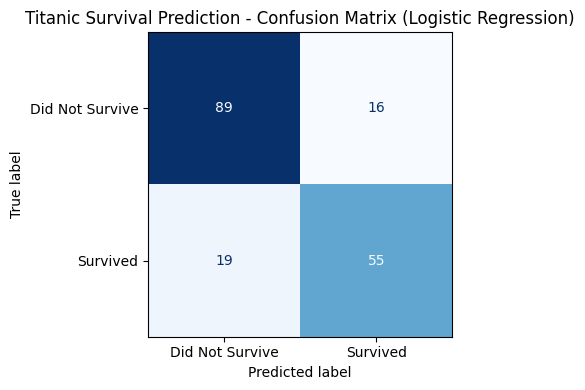

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred_log)   # or y_pred_tree
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Titanic Survival Prediction - Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.savefig("titanic_confusion_matrix.png", dpi=300)
plt.show()


### Feature Importance Visualization (Decision Tree)

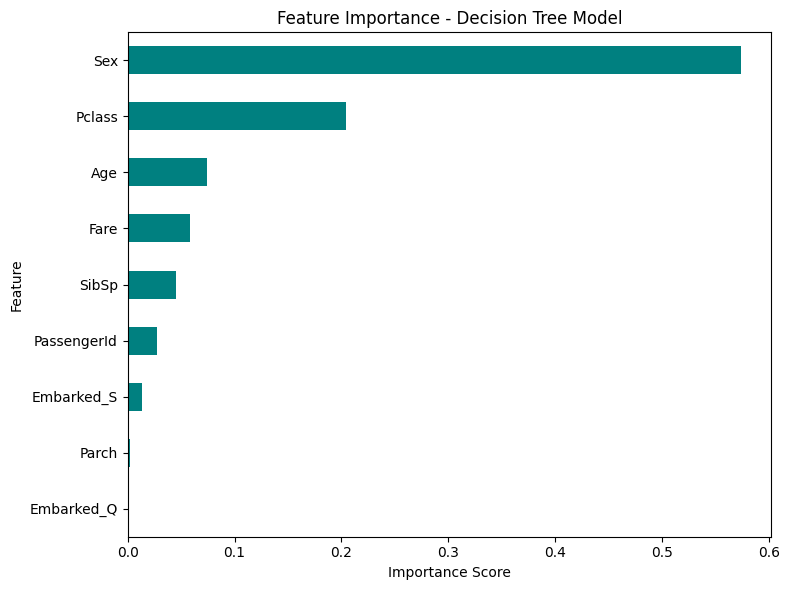

In [23]:
# Get feature importances from Decision Tree
importances = pd.Series(tree_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance - Decision Tree Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()


### Model Accuracy Comparison Bar Chart

C:\Users\Dell\AppData\Local\Temp\ipykernel_24008\2768544364.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_results, palette='viridis')


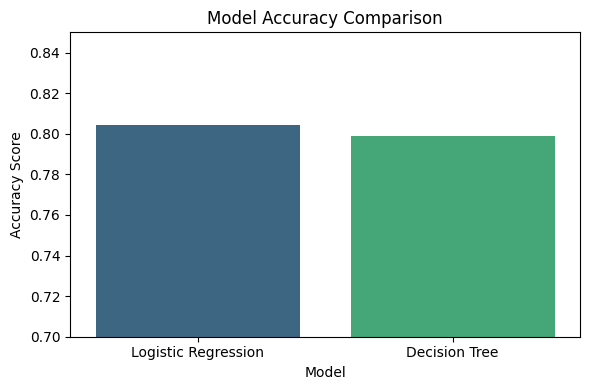

In [24]:
# Compare accuracies visually
accuracy_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_tree)
    ]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Accuracy', data=accuracy_results, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylim(0.7, 0.85)
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300)
plt.show()
